<a href="https://colab.research.google.com/github/Reethz30/FMML-2023/blob/colab/Module1_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data augmentation

FMML Module 1, Lab 3<br>

 In this lab, we will see how augmentation of data samples help in improving the machine learning performance

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
# set randomseed
rng = np.random.default_rng(seed=42)
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp
import math

Augmentation is useful when we have less training data available. Augmentation allows us to 'create' a larger dataset programatically.

For this lab we will use a subset of MNIST that is very small, to better understand the effect of augmentation.

In [ ]:
#loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X/255
test_X = test_X/255

train_X = train_X[::1200,:,:].copy() # subsample. Otherwise it will take too long!
train_y = train_y[::1200].copy() # do the same to the labels

11490434/11490434 [==============================] - 0s 0us/step


Let us borrow a few functions from the previous labs:

In [18]:
def NN1(tdata,tlabel, query):
  d=tdata-query
  sq=d*d
  dist=sq.sum(1)
  label=tlabel[np.argmin(dist)]
  return label

def NN(traindata, trainlabel, testdata):
  traindata = traindata.reshape(-1, 28*28)
  testdata = testdata.reshape(-1,28*28)
  predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
  return predlabel

def Accuracy(gtlabel, predlabel):
  assert len(gtlabel)==len(predlabel), "Length of the groundtruth labels and predicted labels should be the same"
  correct = (gtlabel==predlabel).sum()
  return correct/len(gtlabel)

In this lab, we will use the image pixels themselves as features, instead of extracting features. Each image has 28*28 pixels, so we will flatten them to 784 pixels to use as features. Note that this is very compute intensive and will take a long time.<br>

Let us check the baseline accuracy on the test set without any augmentations. We hope that adding augmentations will help us to get better results.

In [19]:
testpred = NN(train_X, train_y, test_X)
print('Baseline accuracy without augmentation is ', Accuracy(test_y, testpred))

Baseline accuracy without augmentation is  0.6472


Let us try to improve this accuracy using augmentations. When we create augmentations, we have to make sure that the changes reflect what will naturally occur in the dataset. For example, we should not add colour to our samples as an augmentation because they do not naturally occur. We should not also flip the images in MNIST, because flipped images have different meanings for digits.

### Augmentation 1: rotation

Let us try rotating the image a little. We will use skimage library for this.

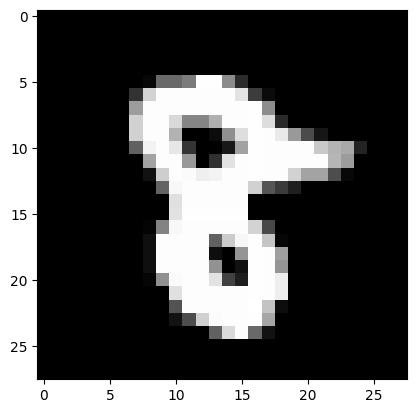

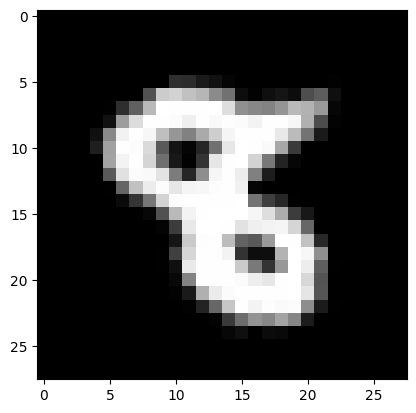

In [20]:
plt.imshow(train_X[2], cmap='gray')
plt.show()
plt.imshow(rotate(train_X[2],25), cmap='gray')

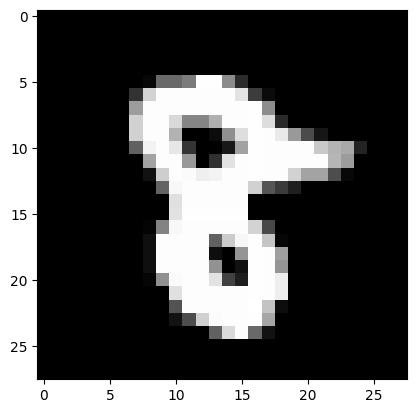

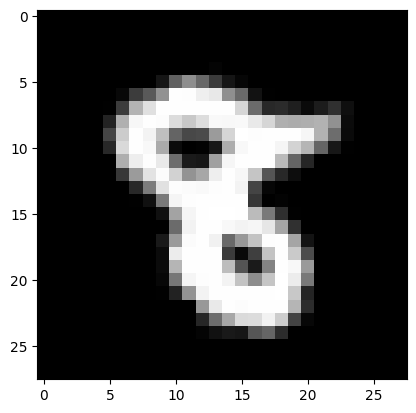

In [25]:
plt.imshow(train_X[2], cmap='gray')
plt.show()
plt.imshow(rotate(train_X[2],15), cmap='gray')

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [26]:
def augRotate(sample, angleconstraint):
  if angleconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)
  angle = rng.random(len(sample))
  angle = (angle-0.5)*angleconstraint
  nsample = sample.copy()
  for ii in range(len(sample)):
    nsample[ii] = rotate(sample[ii], angle[ii])
  return np.squeeze(nsample)

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple.

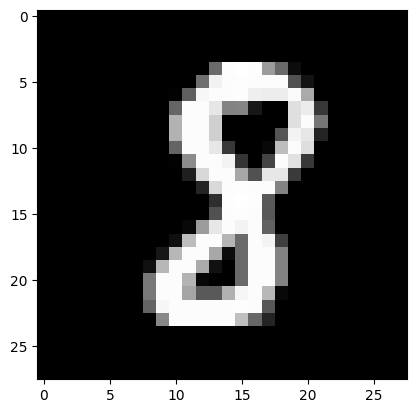

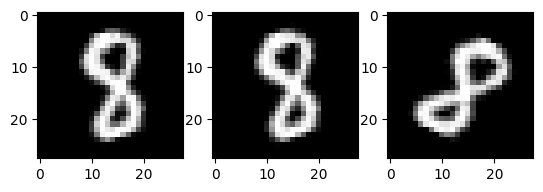

In [29]:
sample = train_X[20]
angleconstraint = 70

plt.imshow(sample, cmap='gray')
plt.show()
plt.subplot(1,3,1)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray')
plt.subplot(1,3,3)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray')

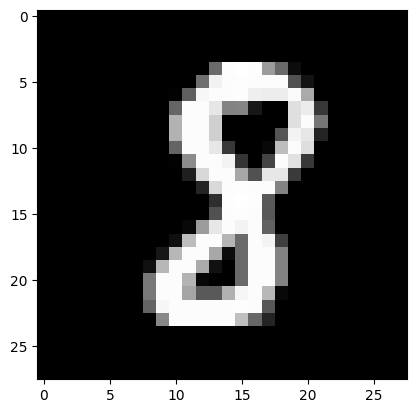

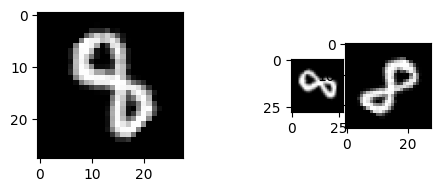

In [38]:
sample = train_X[20]
angleconstraint = 175
plt.imshow(sample, cmap='gray')
plt.show()
plt.subplot(1,3,1)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray')
plt.subplot(1,8,5)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray')
plt.subplot(1,5,4)
plt.imshow(augRotate(sample, angleconstraint), cmap='gray')

Let us augment the whole dataset and see if this improves the test accuracy

In [42]:
# hyperparameters
angleconstraint = 60
naugmentations = 5

augdata = train_X
auglabel = train_y
for ii in range(naugmentations):
  augdata = np.concatenate((augdata, augRotate(train_X, angleconstraint)))
  auglabel = np.concatenate((auglabel, train_y))

testpred = NN(augdata, auglabel, test_X)
print('Accuracy after rotation augmentation is ', Accuracy(test_y, testpred))

Accuracy after rotation augmentation is  0.6563


In [43]:
# hyperparameters
angleconstraint = 150
naugmentations = 3

augdata = train_X
auglabel = train_y
for ii in range(naugmentations):
  augdata = np.concatenate((augdata, augRotate(train_X, angleconstraint)))
  auglabel = np.concatenate((auglabel, train_y))

testpred = NN(augdata, auglabel, test_X)
print('Accuracy after rotation augmentation is ', Accuracy(test_y, testpred))

Accuracy after rotation augmentation is  0.6293


The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint.

In [57]:
angleconstraints = [0,10,20,30,40,50,60,70,80,90]
accuracies = np.zeros(len(angleconstraints), np.dtype(float))

for ii in range(len(angleconstraints)):
  augdata = train_X
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotate(train_X, angleconstraints[ii])))
    auglabel = np.concatenate((auglabel, train_y))
  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after rotation augmentation constrained by ',angleconstraints[ii], ' is ', accuracies[ii], flush=True)

Accuracy after rotation augmentation constrained by  0  is  0.6472
Accuracy after rotation augmentation constrained by  10  is  0.6595
Accuracy after rotation augmentation constrained by  20  is  0.6704
Accuracy after rotation augmentation constrained by  30  is  0.6878
Accuracy after rotation augmentation constrained by  40  is  0.6562
Accuracy after rotation augmentation constrained by  50  is  0.6553
Accuracy after rotation augmentation constrained by  60  is  0.6448
Accuracy after rotation augmentation constrained by  70  is  0.6538
Accuracy after rotation augmentation constrained by  80  is  0.6567
Accuracy after rotation augmentation constrained by  90  is  0.6441


Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

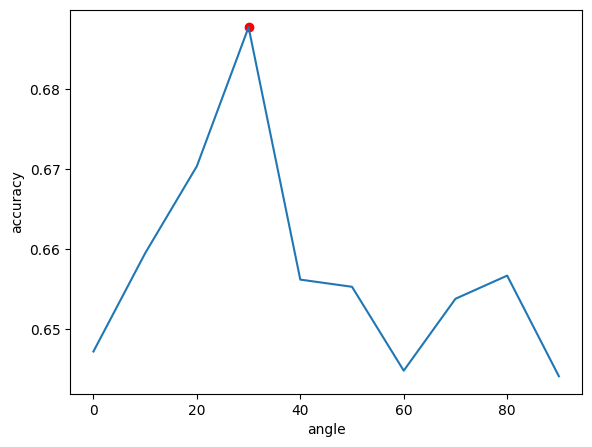

In [58]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(angleconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c='red')

In [60]:
angleconstraints1 = [0,2,6,10,22,31,45,59,63,70,88,92,100]
accuracies1 = np.zeros(len(angleconstraints1), np.dtype(float))

for ii in range(len(angleconstraints1)):
  augdata1 = train_X
  auglabel1 = train_y
  for jj in range(naugmentations):
    augdata1 = np.concatenate((augdata1, augRotate(train_X, angleconstraints1[ii])))
    auglabel1 = np.concatenate((auglabel1, train_y))
  testpred = NN(augdata1, auglabel1, test_X)
  accuracies1[ii] = Accuracy(test_y, testpred)
  print('Accuracy after rotation augmentation constrained by ',angleconstraints1[ii], ' is ', accuracies1[ii], flush=True)

Accuracy after rotation augmentation constrained by  0  is  0.6472
Accuracy after rotation augmentation constrained by  2  is  0.6551
Accuracy after rotation augmentation constrained by  6  is  0.6585
Accuracy after rotation augmentation constrained by  10  is  0.6582
Accuracy after rotation augmentation constrained by  22  is  0.6821
Accuracy after rotation augmentation constrained by  31  is  0.6665
Accuracy after rotation augmentation constrained by  45  is  0.6666
Accuracy after rotation augmentation constrained by  59  is  0.6473
Accuracy after rotation augmentation constrained by  63  is  0.667
Accuracy after rotation augmentation constrained by  70  is  0.6526
Accuracy after rotation augmentation constrained by  88  is  0.6288
Accuracy after rotation augmentation constrained by  92  is  0.6142
Accuracy after rotation augmentation constrained by  100  is  0.6563


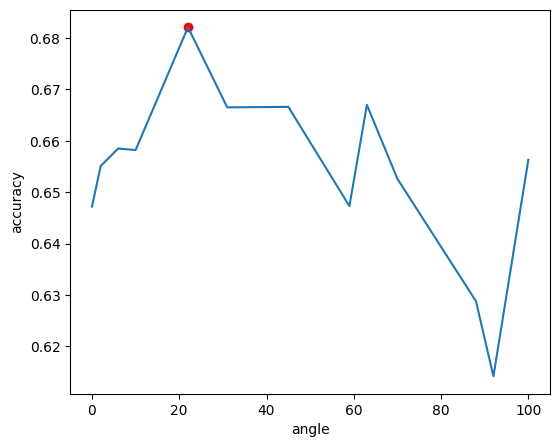

In [62]:
fig1= plt.figure()
ax1 = fig1.add_axes([0.1, 0.2, 0.75,0.8])
ax1.plot(angleconstraints1, accuracies1)
ax1.set_xlabel('angle')
ax1.set_ylabel('accuracy')
maxind = np.argmax(accuracies1)
plt.scatter(angleconstraints1[maxind], accuracies1[maxind], c='red')

Let us try one more augmentation: shear. Here is what this looks like:

In [63]:
def shear(sample, amount):
  tform = AffineTransform(shear = amount)
  img = warp(sample, tform)
  col = img.sum(0).nonzero()[0]
  row = img.sum(1).nonzero()[0]
  if len(col)>0 and len(row)>0:
    xshift = int(sample.shape[0]/2 - (row[0]+row[-1])/2)
    yshift = int(sample.shape[1]/2 - (col[0]+col[-1])/2)
    img = np.roll(img, (xshift, yshift),(0,1))
  return img

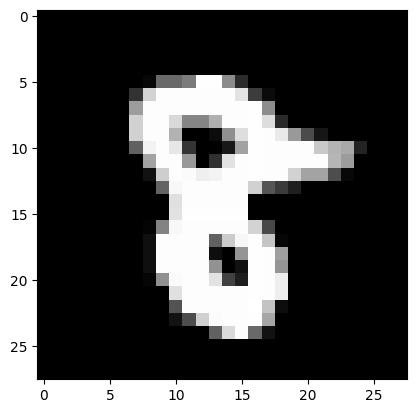

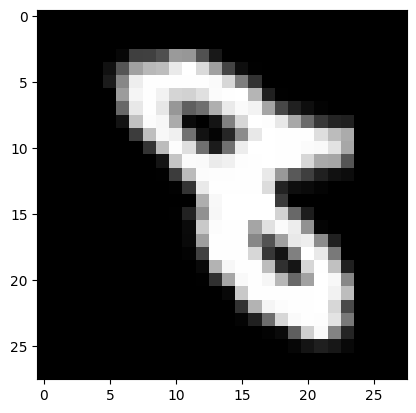

In [64]:
sample = train_X[2]
plt.imshow(sample, cmap='gray')
plt.show()
plt.imshow(shear(sample, 0.4), cmap='gray')

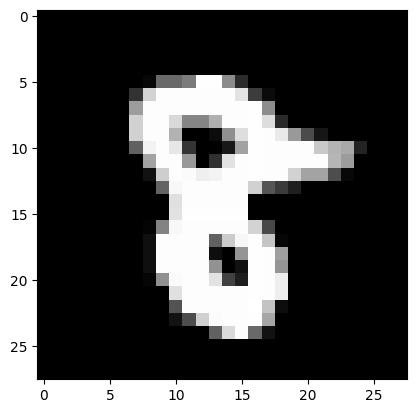

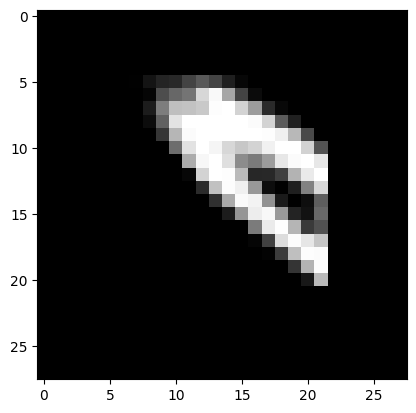

In [66]:
sample = train_X[2]
plt.imshow(sample, cmap='gray')
plt.show()
plt.imshow(shear(sample, 0.9), cmap='gray')

Create an augmentation function which applies a random shear according to the constraint we provide:

In [67]:
def augShear(sample, shearconstraint):
  if shearconstraint==0:
    return sample
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)
  amt = rng.random(len(sample))
  amt = (amt-0.5)*shearconstraint
  nsample = sample.copy()
  for ii in range(len(sample)):
    nsample[ii] = shear(sample[ii], amt[ii])
  return np.squeeze(nsample)

Let us do a grid search to find the best shear constraint.

In [68]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0]
accuracies = np.zeros(len(shearconstraints), np.dtype(float) )
for ii in range(len(shearconstraints)):
  augdata = train_X
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augShear(train_X, shearconstraints[ii])))
    auglabel = np.concatenate((auglabel, train_y))

  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after shear augmentation constrained by ',shearconstraints[ii], ' is ', accuracies[ii], flush=True)

Accuracy after shear augmentation constrained by  0  is  0.6472
Accuracy after shear augmentation constrained by  0.2  is  0.6213
Accuracy after shear augmentation constrained by  0.4  is  0.6325
Accuracy after shear augmentation constrained by  0.6  is  0.6406
Accuracy after shear augmentation constrained by  0.8  is  0.6493
Accuracy after shear augmentation constrained by  1.0  is  0.6439
Accuracy after shear augmentation constrained by  1.2  is  0.6267
Accuracy after shear augmentation constrained by  1.4  is  0.6178
Accuracy after shear augmentation constrained by  1.6  is  0.6296
Accuracy after shear augmentation constrained by  1.8  is  0.5886
Accuracy after shear augmentation constrained by  2.0  is  0.5856


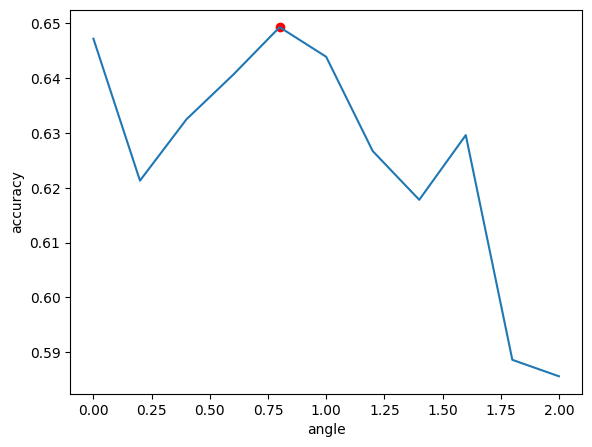

In [69]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(shearconstraints, accuracies)
ax.set_xlabel('angle')
ax.set_ylabel('accuracy')
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c='red')

In [70]:
shearconstraints1 = [0, 0.15,0.26,0.37,0.45,9.56,0.69,0.72,0.81,1,1.36,1.42,1.59,1.62,1.75,1.89,2.0]
accuracies1 = np.zeros(len(shearconstraints1), np.dtype(float) )
for ii in range(len(shearconstraints1)):
  augdata1 = train_X
  auglabel1 = train_y
  for jj in range(naugmentations):
    augdata1 = np.concatenate((augdata1, augShear(train_X, shearconstraints1[ii])))
    auglabel1 = np.concatenate((auglabel1, train_y))

  testpred = NN(augdata1, auglabel1, test_X)
  accuracies1[ii] = Accuracy(test_y, testpred)
  print('Accuracy after shear augmentation constrained by ',shearconstraints1[ii], ' is ', accuracies1[ii], flush=True)

Accuracy after shear augmentation constrained by  0  is  0.6472
Accuracy after shear augmentation constrained by  0.15  is  0.6166
Accuracy after shear augmentation constrained by  0.26  is  0.6172
Accuracy after shear augmentation constrained by  0.37  is  0.6349
Accuracy after shear augmentation constrained by  0.45  is  0.6273
Accuracy after shear augmentation constrained by  9.56  is  0.6179
Accuracy after shear augmentation constrained by  0.69  is  0.6389
Accuracy after shear augmentation constrained by  0.72  is  0.6372
Accuracy after shear augmentation constrained by  0.81  is  0.6451
Accuracy after shear augmentation constrained by  1  is  0.6283
Accuracy after shear augmentation constrained by  1.36  is  0.6332
Accuracy after shear augmentation constrained by  1.42  is  0.6263
Accuracy after shear augmentation constrained by  1.59  is  0.6168
Accuracy after shear augmentation constrained by  1.62  is  0.5985
Accuracy after shear augmentation constrained by  1.75  is  0.6116
A

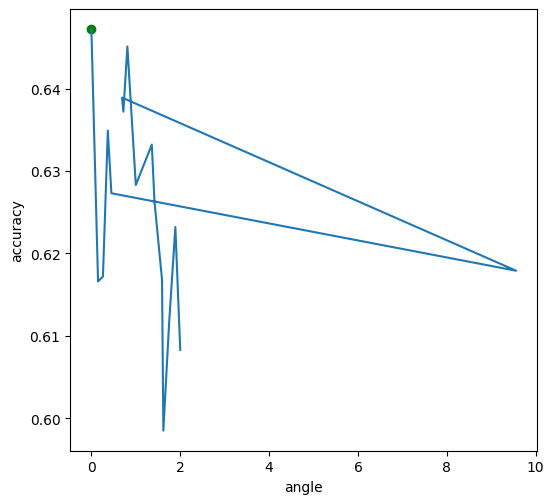

In [71]:
fig1 = plt.figure()
ax1 = fig1.add_axes([0.1, 0.34, 0.73, 0.92])
ax1.plot(shearconstraints1, accuracies1)
ax1.set_xlabel('angle')
ax1.set_ylabel('accuracy')
maxind = np.argmax(accuracies1)
plt.scatter(shearconstraints1[maxind], accuracies1[maxind], c='green')

We can do multiple augmentations at the same time. Here is a function to do both shear and rotation to the sample. In this case, we will have two hyperparameters.

In [72]:
def augRotateShear(sample, angleconstraint, shearconstraint):
  if len(sample.shape)==2:
    sample = np.expand_dims(sample, 0)
  amt = rng.random(len(sample))
  amt = (amt-0.5)*shearconstraint
  angle = rng.random(len(sample))
  angle = (angle-0.5)*angleconstraint
  nsample = sample.copy()
  for ii in range(len(sample)):
    nsample[ii] = rotate(shear(sample[ii], amt[ii]), angle[ii])
  return np.squeeze(nsample)

Since we have two hyperparameters, we have to do the grid search on a 2 dimensional matrix. We can use our previous experience to inform where to search for the best hyperparameters.

In [73]:
shearconstraints = [0, 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6]
angleconstraints = [0,10,20,30,40,50,60]
hyp = cartesian((shearconstraints, angleconstraints))
accuracies = np.zeros(len(hyp), np.dtype(float) )
for ii in range(len(hyp)):

  augdata = train_X
  auglabel = train_y
  for jj in range(naugmentations):
    augdata = np.concatenate((augdata, augRotateShear(train_X, hyp[ii][0], hyp[ii][1])))
    auglabel = np.concatenate((auglabel, train_y))

  testpred = NN(augdata, auglabel, test_X)
  accuracies[ii] = Accuracy(test_y, testpred)
  print('Accuracy after augmentation shear:',hyp[ii][0], 'angle:',hyp[ii][1], ' is ', accuracies[ii], flush=True)

Accuracy after augmentation shear: 0.0 angle: 0.0  is  0.6332
Accuracy after augmentation shear: 0.0 angle: 10.0  is  0.6216
Accuracy after augmentation shear: 0.0 angle: 20.0  is  0.6263
Accuracy after augmentation shear: 0.0 angle: 30.0  is  0.6183
Accuracy after augmentation shear: 0.0 angle: 40.0  is  0.6082
Accuracy after augmentation shear: 0.0 angle: 50.0  is  0.6172
Accuracy after augmentation shear: 0.0 angle: 60.0  is  0.6172
Accuracy after augmentation shear: 0.2 angle: 0.0  is  0.6335
Accuracy after augmentation shear: 0.2 angle: 10.0  is  0.6082
Accuracy after augmentation shear: 0.2 angle: 20.0  is  0.5912
Accuracy after augmentation shear: 0.2 angle: 30.0  is  0.6016
Accuracy after augmentation shear: 0.2 angle: 40.0  is  0.6028
Accuracy after augmentation shear: 0.2 angle: 50.0  is  0.5755
Accuracy after augmentation shear: 0.2 angle: 60.0  is  0.6193
Accuracy after augmentation shear: 0.4 angle: 0.0  is  0.6324
Accuracy after augmentation shear: 0.4 angle: 10.0  is  0.

Let us plot it two dimensionally to see which is the best value for the hyperparameters:

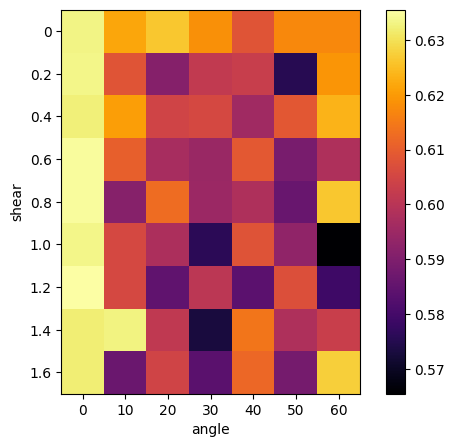

In [74]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
im = ax.imshow(accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap='inferno')
ax.set_xlabel('angle')
ax.set_ylabel('shear')
ax.set_xticks(np.arange(len(angleconstraints)));
ax.set_xticklabels(angleconstraints);
ax.set_yticks(np.arange(len(shearconstraints)));
ax.set_yticklabels(shearconstraints);
plt.colorbar(im)

It seems that rotation and shear don't mix! The best accuracy is when rotation is zero.

## Questions
Try these questions for better understanding. You may not be able to solve all of them.
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
2. Can you increase the accuracy by increasing the number of augmentations from each sample?
3. Try implementing a few augmentations of your own and experimenting with them. A good reference is <a href=https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/>here. </a>
4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?

Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch.